# Initialization

In [40]:
import blackhc.notebook

In [41]:
import os
os.environ["LOCAL_RANK"] = "0"

In [42]:
import al_notebook.results_loader as rl
import al_notebook.plots as alp
from acquisition_functions import AcquisitionFunction
from acquisition_method import AcquisitionMethod
from dataset_enum import DatasetEnum

In [43]:
import torch
import numpy as np
import itertools
import prettyprinter as pp
import matplotlib.pyplot as plt
%matplotlib inline

# Binary COVID Results

In [44]:
def acc_label_axes(metric):
    plt.xlabel('Acquired dataset size')
    plt.ylabel(metric)

In [45]:
stores = rl.load_experiment_results('EMORY_COVID/binary')

In [46]:
stores.keys()

dict_keys(['EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_58.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_254.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_1234.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_1979.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_1997.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_4321.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_1970.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_8888.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_9031.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_entropy_9971.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_lc_58.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_lc_254.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_lc_1234.py', 'EMORY_COVID/binary/covid_full_resnet_binary_scratch_lc_1979.py', 'EMORY_COVID/binary/c

In [47]:
pp.pprint(rl.get_any(stores).args)

al_notebook.results_loader._args(
    experiment_description='COVID BINARY:RESNET BN DROPOUT ENTROPY (SCRATCH)',
    batch_size=16,
    scoring_batch_size=32,
    test_batch_size=64,
    validation_set_size=500,
    early_stopping_patience=3,
    epochs=30,
    epoch_samples=5056,
    num_inference_samples=100,
    available_sample_k=20,
    target_num_acquired_samples=1000,
    target_accuracy=0.9375,
    quickquick=False,
    seed=58,
    log_interval=20,
    initial_samples_per_class=25,
    initial_samples=None,
    balanced_validation_set=False,
    balanced_test_set=False,
    no_cuda=False,
    experiment_task_id='covid_full_resnet_binary_scratch_entropy_58',
    experiments_laaos='./experiment_configs/EMORY_COVID/scratch_binary_config.py',
    type=acquisition_functions.AcquisitionFunction.entropy_sampling,
    acquisition_method=acquisition_method.AcquisitionMethod.independent,
    dataset=dataset_enum.DatasetEnum.covid_binary
)


In [48]:
pp.pprint(rl.diff_args(stores))

{
    'experiment_description': {
        'COVID BINARY:RESNET BN DROPOUT MARGIN SAMPLING (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT MULTI BALD (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT VARIATIONAL RATIOS (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT LEAST CONFIDENCE (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT MEAN STD (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT RANDOM (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT ENTROPY (SCRATCH)'
    },
    'type': {
        acquisition_functions.AcquisitionFunction.mean_stddev,
        acquisition_functions.AcquisitionFunction.margin_sampling,
        acquisition_functions.AcquisitionFunction.entropy_sampling,
        acquisition_functions.AcquisitionFunction.bald,
        acquisition_functions.AcquisitionFunction.least_confidence,
        acquisition_functions.AcquisitionFunction.random,
        acquisition_functions.AcquisitionFunction.variation_ratios
    },
    'acquisition_method': {
        acqui

### Binary Baseline

In [49]:
def round_down_to_nearest_5(number):
    """
    Rounds the given number down to the nearest multiple of 5.
    
    Parameters:
    number (float or int): The number to be rounded down.
    
    Returns:
    int: The number rounded down to the nearest multiple of 5.
    """
    return 5 * np.floor(number / 5)

In [50]:
binary_baseline = {'accuracy': 0.9375, 'nll': 0.4526682557730839, 'f1': 0.8538900048862588, 'precision': 0.9098557692307692, 'recall': 0.8155581260844419, 'ROC_AUC': 0.9107610725653014, 'PRC_AUC': 0.9895504989378878, 'specificity': 0.8629651050703682}
binary_baseline = {k:round(v*100,2) for k,v in binary_baseline.items()}
binary_baseline

{'accuracy': 93.75,
 'nll': 45.27,
 'f1': 85.39,
 'precision': 90.99,
 'recall': 81.56,
 'ROC_AUC': 91.08,
 'PRC_AUC': 98.96,
 'specificity': 86.3}

In [51]:
# this script basically creates baselines that are reasonable
# one baseline is from the no_al experiment run
# the other baseline is 3-9% lower just to get an idea
lower_binary_baseline = {}
threshold_key = 3
for k,v in binary_baseline.items():
    rounded_down = round_down_to_nearest_5(v)
    if abs(rounded_down - v) < threshold_key:
        rounded_down = round_down_to_nearest_5(rounded_down-1)

    lower_binary_baseline[k] = rounded_down

lower_binary_baseline

{'accuracy': 90.0,
 'nll': 40.0,
 'f1': 80.0,
 'precision': 85.0,
 'recall': 75.0,
 'ROC_AUC': 85.0,
 'PRC_AUC': 95.0,
 'specificity': 80.0}

# Entropy vs Mean STD vs Random

In [52]:
for show_b in (10, ):
    def filter_exps(name, store):
        vip_args = rl.get_vip_args(store)
        if vip_args.nis == 0:
            return False
        if (vip_args.am, vip_args.af) in [
            # (AcquisitionMethod.multibald, AcquisitionFunction.bald),
            (AcquisitionMethod.independent, AcquisitionFunction.random),
            (AcquisitionMethod.independent, AcquisitionFunction.mean_stddev),
            # (AcquisitionMethod.independent, AcquisitionFunction.variation_ratios),
            (AcquisitionMethod.independent, AcquisitionFunction.entropy_sampling),
            # (AcquisitionMethod.independent, AcquisitionFunction.least_confidence),
            # (AcquisitionMethod.independent, AcquisitionFunction.margin_sampling)
        ]:
            return True
        if vip_args.af != AcquisitionFunction.random:
            if vip_args.k not in (10, ) or vip_args.b not in (show_b, ):
                return False
        return True

    filtered = rl.filter_dict(stores, kv=filter_exps)
    pp.pprint(rl.diff_args(filtered))

    def key2text(name, store):
        vip_args = rl.get_vip_args(store)
        am, af = vip_args.am, vip_args.af
        key_map = {
            (AcquisitionMethod.independent, AcquisitionFunction.random): 'Random',
            # (AcquisitionMethod.independent, AcquisitionFunction.bald): 'BALD',
            # (AcquisitionMethod.independent, AcquisitionFunction.variation_ratios): 'Var Ratios',
            (AcquisitionMethod.independent, AcquisitionFunction.mean_stddev): 'Mean STD',
            # (AcquisitionMethod.multibald, AcquisitionFunction.bald): 'BatchBALD',
            (AcquisitionMethod.independent, AcquisitionFunction.entropy_sampling): 'Entropy Sampling',
            # (AcquisitionMethod.independent, AcquisitionFunction.least_confidence): 'Least Confidence',
            # (AcquisitionMethod.independent, AcquisitionFunction.margin_sampling): 'Margin Sampling'
        }
        return key_map.get((am, af), ValueError(vip_args))

    grouped_by = rl.groupby_dict(filtered, key_kv=key2text)
    pp.pprint(rl.map_dict(grouped_by, v=lambda stores: rl.get_stores_info(stores)))

    metrics = {
        'accuracy': rl.aggregate_accuracies,
        'f1': rl.aggregate_f1,
        'precision': rl.aggregate_precision,
        'recall': rl.aggregate_recall,
        'AU_ROC': rl.aggregate_auroc,
        'AU_PRC': rl.aggregate_auprc,
        'nll': rl.aggregate_loss,
        'sensitivity': rl.aggregate_sensitivity,
        'specificity': rl.aggregate_specificity
    }
    thresholds = {
        'accuracy': (lower_binary_baseline['accuracy'], binary_baseline['accuracy']),
        'f1': (lower_binary_baseline['f1'], binary_baseline['f1']),
        'precision': (lower_binary_baseline['precision'], binary_baseline['precision']),
        'recall': (lower_binary_baseline['recall'], binary_baseline['recall']),
        'AU_ROC': (lower_binary_baseline['ROC_AUC'], binary_baseline['ROC_AUC']),
        'AU_PRC': (lower_binary_baseline['PRC_AUC'], binary_baseline['PRC_AUC']),
        'nll': (lower_binary_baseline['nll'], binary_baseline['nll']),
        'sensitivity': (lower_binary_baseline['recall'], binary_baseline['recall']),
        'specificity': (lower_binary_baseline['specificity'], binary_baseline['specificity'])
    }

    grouped_by_metric = {metric: rl.map_dict(grouped_by, v=lambda stores: func(stores, thresholds=thresholds[metric])) for metric, func in metrics.items()}
    # acquisition_functions_list = ['BatchBALD', 'Random', 'Var Ratios', 'Mean STD', 'Entropy Sampling', 'Least Confidence', 'Margin Sampling']
    acquisition_functions_list = ['Random', 'Entropy Sampling', 'Mean STD']

    sorted_dicts = {metric: {key: grouped_by_metric[metric][key] for key in acquisition_functions_list} for metric in metrics}

    # figsize = (16, 9)

    # for metric in metrics:
    #     plt.figure(figsize=figsize)
    #     alp.plot_aggregated_groups(sorted_dicts[metric], show_num_trials=True, show_quantiles=False, show_thresholds=True)
        
    #     # Get the min and max y values for the current metric
    #     # Stacking accuracies for each key
    #     y_values = np.array([])
    #     for key, value in sorted_dicts[metric].items():
    #         accuracies_list = value.accuracies
    #         y_values = np.append(y_values, np.hstack(accuracies_list))
    #     y_values = np.where(y_values==0, np.nan, y_values)
    #     if metric == 'loss' or metric == 'nll':
    #         y_values = np.where(y_values==np.nanmax(y_values), np.nan, y_values)
    #     min_y = np.nanmin(y_values)
    #     max_y = np.nanmax(y_values)
        
    #     # Set the y-axis limits dynamically
    #     y_margin = 0.01 * (max_y - min_y)
    #     # print(min_y, max_y, min_y - y_margin, max_y + y_margin)
    #     plt.axis([50, 525, min_y - y_margin, max_y + y_margin])
        
    #     acc_label_axes(metric=metric.capitalize())
    #     plt.grid(True)
    #     plt.legend(loc='lower right')
    #     plt.title(f'COVID Binary {metric.capitalize()}')
    #     output_path = blackhc.notebook.original_dir + f'/COVID_binary_{metric}.png'
    #     alp.plot_save(output_path, dpi=300)
    #     plt.show()


{
    'experiment_description': {
        'COVID BINARY:RESNET BN DROPOUT ENTROPY (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT RANDOM (SCRATCH)',
        'COVID BINARY:RESNET BN DROPOUT MEAN STD (SCRATCH)'
    },
    'type': {
        acquisition_functions.AcquisitionFunction.mean_stddev,
        acquisition_functions.AcquisitionFunction.random,
        acquisition_functions.AcquisitionFunction.entropy_sampling
    },
    'num_acquired_points': {
        290,
        450,
        1050,
        930,
        390,
        550,
        490,
        330,
        970,
        590,
        750,
        270,
        430,
        570,
        310,
        730,
        250,
        350
    },
    'local_rank': {0, None}
}
{
    'Entropy Sampling': {
        'num_trials': 10,
        'experiment_description': {
            'COVID BINARY:RESNET BN DROPOUT ENTROPY (SCRATCH)'
        },
        'num_inference_samples': {100},
        'available_sample_k': {20},
        'quickquick': {False},


In [53]:
def get_missclass_vals(metric, sampler='Entropy Sampling', one_minus=False):
    random_accuracies = sorted_dicts[metric]['Random'].accuracies
    sampler_accuracies = sorted_dicts[metric][sampler].accuracies

    # Get the last elements from 'Entropy Sampling' arrays
    sampler_last_indices = [len(arr) - 1 for arr in sampler_accuracies]
    
    # Get corresponding values from 'Random' arrays
    try:
        random_values = [random_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
        sampler_values = [sampler_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
    except IndexError:
        random_values = []
        for i, idx in enumerate(sampler_last_indices):
            try:
                # check and see if random samples exists at index of smart sampler
                random_values.append(random_accuracies[i][idx])
            except:
                # if not, then choose the last index in random sampler since it reached baseline
                random_values.append(random_accuracies[i][-1])
        sampler_values = [sampler_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
    
    if one_minus:
        # Calculate 1 - accuracy values
        random_errors = [1-val for val in random_values]
        sampler_errors = [1-val for val in sampler_values]
    else:
        # Calculate 1 - accuracy values
        random_errors = [val for val in random_values]
        sampler_errors = [val for val in sampler_values]
    
    # Calculate mean and standard deviation
    mean_random_error = np.mean(random_errors)
    std_random_error = np.std(random_errors)
    
    mean_sampler_error = np.mean(sampler_errors)
    std_sampler_error = np.std(sampler_errors)
    return mean_random_error, std_random_error, mean_sampler_error, std_sampler_error


In [54]:
# def get_missclass_vals(metric, one_minus=False):
#     random_accuracies = sorted_dicts[metric]['Random'].accuracies
#     entropy_accuracies = sorted_dicts[metric]['Entropy Sampling'].accuracies
#     mean_std_accuracies = sorted_dicts[metric]['Mean STD'].accuracies

#     # Get the last elements from 'Entropy Sampling' arrays
#     entropy_last_indices = [len(arr) - 1 for arr in entropy_accuracies]
#     mean_std_last_indices = [len(arr) - 1 for arr in mean_std_accuracies]
#     print(entropy_last_indices)
#     print(mean_std_last_indices)
#     sampler_last_indices = [min(a, b) for a, b in zip(entropy_last_indices, mean_std_last_indices)]
    
#     # Get corresponding values from 'Random' arrays
#     try:
#         random_values = [random_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
#         entropy_values = [entropy_accuracies[i][idx] for i, idx in enumerate(entropy_last_indices)]
#         mean_std_values = [mean_std_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
#     except IndexError:
#         random_values = []
#         for i, idx in enumerate(sampler_last_indices):
#             try:
#                 # check and see if random samples exists at index of smart sampler
#                 random_values.append(random_accuracies[i][idx])
#             except:
#                 # if not, then choose the last index in random sampler since it reached baseline
#                 random_values.append(random_accuracies[i][-1])
        
#         entropy_values = [entropy_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
#         mean_std_values = [mean_std_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
    
#     if one_minus:
#         # Calculate 1 - accuracy values
#         random_errors = [1-val for val in random_values]
#         entropy_errors = [1-val for val in entropy_values]
#         mean_std_errors = [1-val for val in mean_std_values]
#     else:
#         # Calculate 1 - accuracy values
#         random_errors = [val for val in random_values]
#         entropy_errors = [val for val in entropy_values]
#         mean_std_errors = [val for val in mean_std_values]
    
#     # Calculate mean and standard deviation
#     mean_random_error = np.mean(random_errors)
#     std_random_error = np.std(random_errors)
    
#     mean_entropy_error = np.mean(entropy_errors)
#     std_entropy_error = np.std(entropy_errors)

#     mean_mean_std_error = np.mean(mean_std_errors)
#     std_mean_std_error = np.std(mean_std_errors)
    
#     return mean_random_error, std_random_error, mean_entropy_error, std_entropy_error, mean_mean_std_error, std_mean_std_error


In [55]:
# def get_missclass_vals(metric, sampler, one_minus=False):
#     sampler_accuracies = sorted_dicts[metric][sampler].accuracies

#     # Get the last elements from 'Entropy Sampling' arrays
#     sampler_last_indices = [len(arr) - 1 for arr in sampler_accuracies]
    
#     # Get corresponding values from 'Random' arrays
#     try:
#         sampler_values = [sampler_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]
#     except IndexError:
#         sampler_values = []
#         for i, idx in enumerate(sampler_last_indices):
#             try:
#                 # check and see if random samples exists at index of smart sampler
#                 sampler_values.append(sampler_accuracies[i][idx])
#             except:
#                 # if not, then choose the last index in random sampler since it reached baseline
#                 sampler_values.append(sampler_accuracies[i][-1])
#         sampler_values = [sampler_accuracies[i][idx] for i, idx in enumerate(sampler_last_indices)]

#     if one_minus:
#         # Calculate 1 - accuracy values
#         sampler_errors = [1-val for val in sampler_values]
#     else:
#         # Calculate 1 - accuracy values
#         sampler_errors = [val for val in sampler_values]
    
#     # Calculate mean and standard deviation
#     mean_sampler_error = np.mean(sampler_errors)
#     std_sampler_error = np.std(sampler_errors)
#     return mean_sampler_error, std_sampler_error


In [56]:
# samplers = ['Random', 'Entropy Sampling', 'Mean STD']
# for metric in metrics:
#     mean_errors = []
#     std_errors = []
    
#     # Gather mean and std errors for each sampler
#     output = get_missclass_vals(metric=metric, one_minus=False)
#     mean_random_error, std_random_error, mean_entropy_error, std_entropy_error, mean_mean_std_error, std_mean_std_error = output
    
#     mean_errors.append(mean_random_error)
#     mean_errors.append(mean_entropy_error)
#     mean_errors.append(mean_mean_std_error)
    
#     std_errors.append(std_random_error)
#     std_errors.append(std_entropy_error)
#     std_errors.append(std_mean_std_error)
    
#     # Plotting
#     labels = samplers
    
#     fig, ax = plt.subplots()
    
#     # Define the bar width
#     bar_width = 1
    
#     # Define the positions of the bars
#     bar_positions = np.arange(len(labels))
    
#     # Plotting the bars
#     bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['#FF9999', '#99FF99', '#9999FF'])
    
#     # Adding legend with mean and standard deviation values
#     legend_labels = [
#         f'{sampler} (mean = {mean_error:.2f} ± {std_error:.2f})' for sampler, mean_error, std_error in zip(samplers, mean_errors, std_errors)
#     ]
#     ax.legend(bars, legend_labels, fontsize=12)

#     # Labels and title with larger font sizes
#     ax.set_ylabel(f'{metric.capitalize()}', fontsize=14)
#     ax.set_title(f'Mean {metric.capitalize()} with Std Dev Error Bar (Binary)', fontsize=16)
#     ax.set_xticks(bar_positions)
#     ax.set_xticklabels(labels, fontsize=12)
#     ax.tick_params(axis='y', labelsize=12)

#     output_path = blackhc.notebook.original_dir + f'/COVID_binary_{metric}_vs_random.png'
#     alp.plot_save(output_path, dpi=300)
#     plt.show()

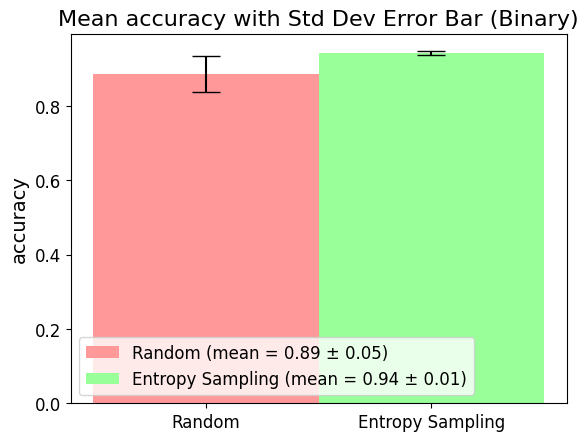

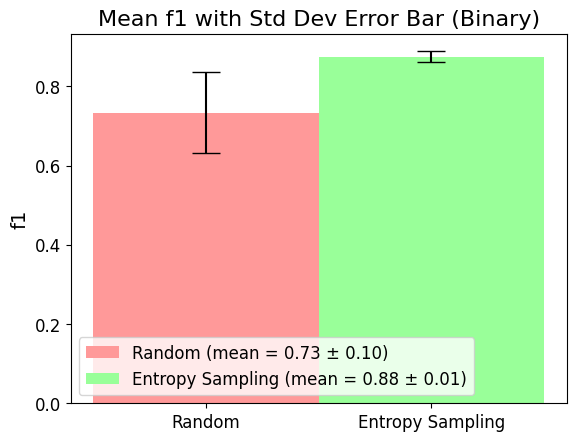

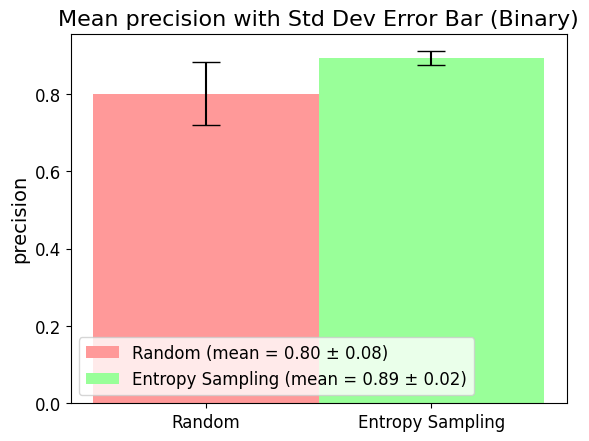

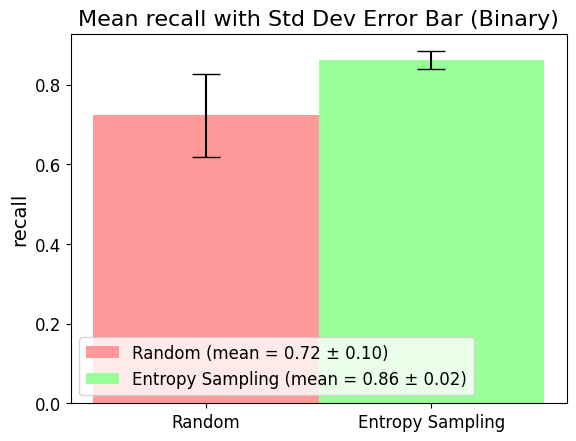

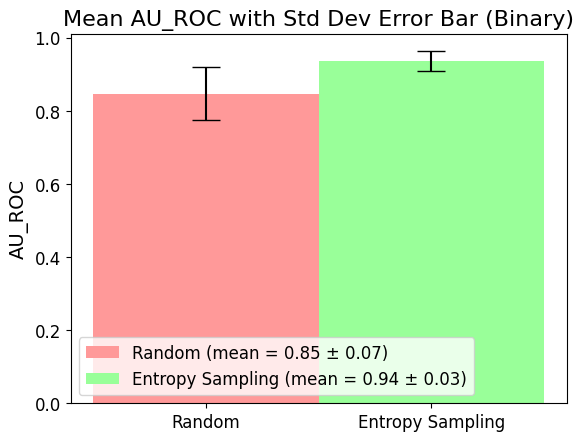

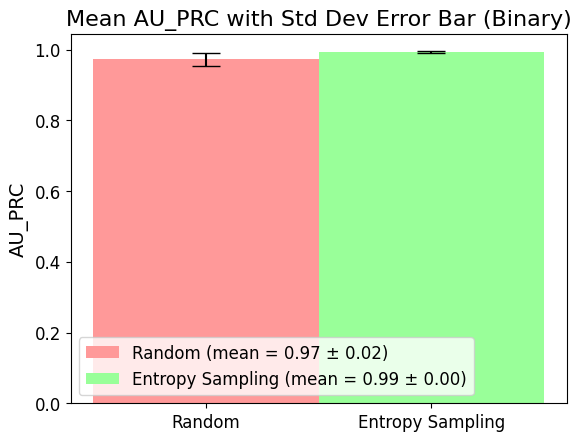

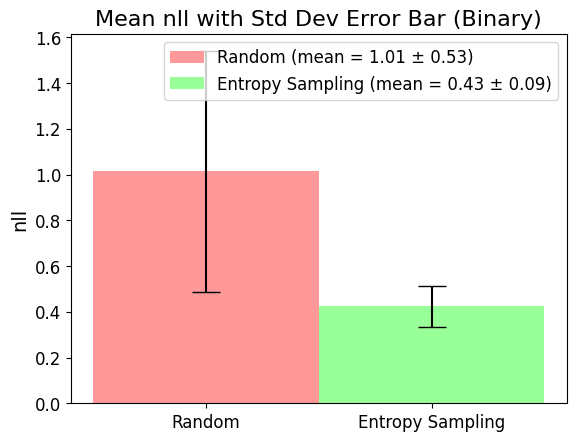

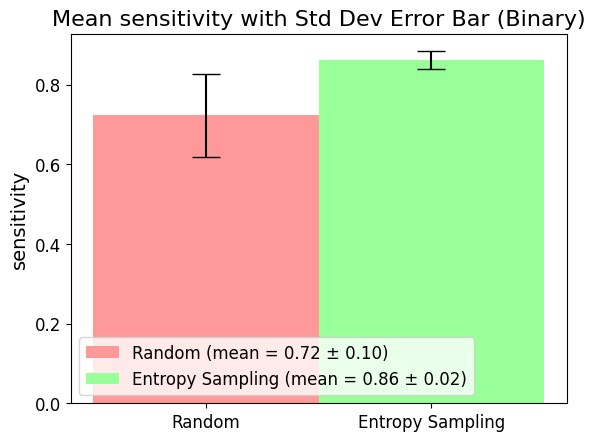

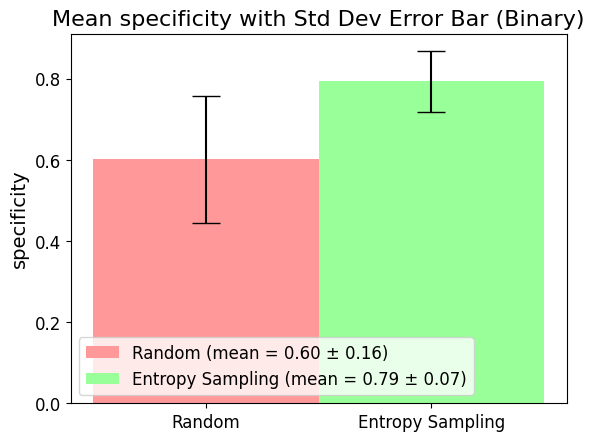

In [57]:
sampler = 'Entropy Sampling'
for metric in metrics:
    mean_random_error, std_random_error, mean_sampler_error, std_sampler_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=False)
    
    # Plotting
    labels = ['Random', sampler]
    mean_errors = [mean_random_error, mean_sampler_error]
    std_errors = [std_random_error, std_sampler_error]
    
    fig, ax = plt.subplots()
    
    # Define the bar width
    bar_width = 1
    
    # Define the positions of the bars
    bar_positions = np.arange(len(labels))
    
    # Plotting the bars
    bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['#FF9999', '#99FF99'])
    
    # Adding legend with mean and standard deviation values
    legend_labels = [
        f'Random (mean = {mean_random_error:.2f} ± {std_random_error:.2f})',
        f'{sampler} (mean = {mean_sampler_error:.2f} ± {std_sampler_error:.2f})'
    ]
    ax.legend(bars, legend_labels, fontsize=12)

    # Labels and title with larger font sizes
    ax.set_ylabel(f'{metric}', fontsize=14)
    ax.set_title(f'Mean {metric} with Std Dev Error Bar (Binary)', fontsize=16)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    output_path = blackhc.notebook.original_dir + f'/COVID_binary_{metric}_vs_random.png'
    alp.plot_save(output_path, dpi=300)
    plt.show()

In [58]:
# samplers = ['Random', 'Entropy Sampling', 'Mean STD']

# # Gather mean and std errors for each sampler
# mean_errors = []
# std_errors = []

# for sampler in samplers:
#     mean_error, std_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=True)
#     mean_errors.append(mean_error)
#     std_errors.append(std_error)

# # Plotting
# labels = samplers

# fig, ax = plt.subplots()

# # Define the bar width
# bar_width = 1

# # Define the positions of the bars
# bar_positions = np.arange(len(labels))

# # Plotting the bars
# bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['blue', 'orange', 'green'])

# # Adding legend with mean and standard deviation values
# legend_labels = [
#     f'{sampler} (mean = {mean_error:.2f} ± {std_error:.2f})' for sampler, mean_error, std_error in zip(samplers, mean_errors, std_errors)
# ]
# ax.legend(bars, legend_labels, fontsize=12)

# # Labels and title with larger font sizes
# ax.set_ylabel('Missclassification Rate', fontsize=14)
# ax.set_title('Mean Missclassification with Std Dev Error Bar (Binary)', fontsize=12)
# ax.set_xticks(bar_positions)
# ax.set_xticklabels(labels, fontsize=12)
# ax.tick_params(axis='y', labelsize=12)

# output_path = blackhc.notebook.original_dir + f'/COVID_binary_missclassification_vs_random.png'
# alp.plot_save(output_path, dpi=300)
# plt.show()

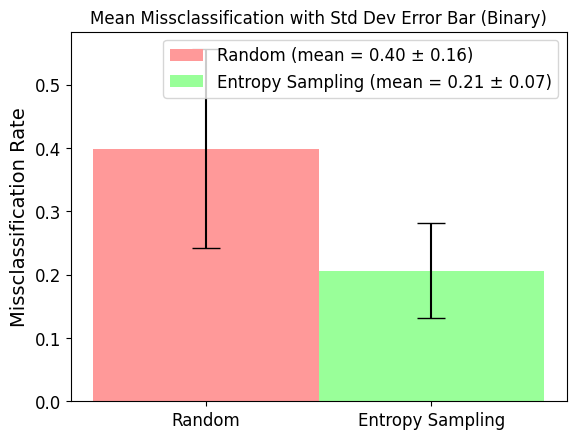

In [62]:
sampler = 'Entropy Sampling'

mean_random_error, std_random_error, mean_sampler_error, std_sampler_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=True)

# Plotting
labels = ['Random', sampler]
mean_errors = [mean_random_error, mean_sampler_error]
std_errors = [std_random_error, std_sampler_error]

fig, ax = plt.subplots()

# Define the bar width
bar_width = 1

# Define the positions of the bars
bar_positions = np.arange(len(labels))

# Plotting the bars
bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['#FF9999', '#99FF99'])

# Adding legend with mean and standard deviation values
legend_labels = [
    f'Random (mean = {mean_random_error:.2f} ± {std_random_error:.2f})',
    f'{sampler} (mean = {mean_sampler_error:.2f} ± {std_sampler_error:.2f})'
]
ax.legend(bars, legend_labels, fontsize=12)

# Labels and title with larger font sizes
ax.set_ylabel(f'Missclassification Rate', fontsize=14)
ax.set_title(f'Mean Missclassification with Std Dev Error Bar (Binary)', fontsize=12)
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

output_path = blackhc.notebook.original_dir + f'/COVID_binary_missclassification_vs_random.png'
alp.plot_save(output_path, dpi=300)
plt.show()

# Multi COVID Results

In [63]:
stores = rl.load_experiment_results('EMORY_COVID/multi')

In [64]:
stores.keys()

dict_keys(['EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_58.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_254.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_1234.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_1979.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_1997.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_4321.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_7991.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_8888.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_9031.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_entropy_9971.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_lc_58.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_lc_254.py', 'EMORY_COVID/multi/covid_full_resnet_multi_no_mild_scratch_lc_1234.py', 'EMORY_CO

In [65]:
pp.pprint(rl.get_any(stores).args)

al_notebook.results_loader._args(
    experiment_description='COVID MULTI:RESNET BN DROPOUT ENTROPY (SCRATCH)',
    batch_size=16,
    scoring_batch_size=32,
    test_batch_size=64,
    validation_set_size=500,
    early_stopping_patience=3,
    epochs=30,
    epoch_samples=5056,
    num_inference_samples=100,
    available_sample_k=20,
    target_num_acquired_samples=1000,
    target_accuracy=0.7025,
    quickquick=False,
    seed=58,
    log_interval=20,
    initial_samples_per_class=25,
    initial_samples=None,
    balanced_validation_set=False,
    balanced_test_set=False,
    no_cuda=False,
    experiment_task_id='covid_full_resnet_multi_no_mild_scratch_entropy_58',
    experiments_laaos='./experiment_configs/EMORY_COVID/scratch_multi_no_mild_config.py',
    type=acquisition_functions.AcquisitionFunction.entropy_sampling,
    acquisition_method=acquisition_method.AcquisitionMethod.independent,
    dataset=dataset_enum.DatasetEnum.covid_multi
)


In [66]:
pp.pprint(rl.diff_args(stores))

{
    'experiment_description': {
        'COVID MULTI:RESNET BN DROPOUT ENTROPY (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT RANDOM (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT LEAST CONFIDENCE (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT MEAN STD (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT MULTI BALD (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT VARIATIONAL RATIOS (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT MARGIN SAMPLING (SCRATCH)'
    },
    'type': {
        acquisition_functions.AcquisitionFunction.mean_stddev,
        acquisition_functions.AcquisitionFunction.margin_sampling,
        acquisition_functions.AcquisitionFunction.entropy_sampling,
        acquisition_functions.AcquisitionFunction.bald,
        acquisition_functions.AcquisitionFunction.least_confidence,
        acquisition_functions.AcquisitionFunction.random,
        acquisition_functions.AcquisitionFunction.variation_ratios
    },
    'acquisition_method': {
        acquisition_

### Multi Baseline

In [67]:
multi_baseline = {'accuracy': 0.7025862068965517, 'nll': 0.5564656750909214, 'f1': 0.6940048474479613, 'precision': 0.7351185322790164, 'recall': 0.670069542612388, 'ROC_AUC': 0.8597412109375, 'PRC_AUC': 0.7525973741946765, 'specificity': 0.8235702311624876}
multi_baseline = {k:round(v*100,2) for k,v in multi_baseline.items()}
multi_baseline

{'accuracy': 70.26,
 'nll': 55.65,
 'f1': 69.4,
 'precision': 73.51,
 'recall': 67.01,
 'ROC_AUC': 85.97,
 'PRC_AUC': 75.26,
 'specificity': 82.36}

In [68]:
# this script basically creates baselines that are reasonable
# one baseline is from the no_al experiment run
# the other baseline is 3-9% lower just to get an idea
lower_multi_baseline = {}
threshold_key = 3
for k,v in multi_baseline.items():
    rounded_down = round_down_to_nearest_5(v)
    if abs(rounded_down - v) < threshold_key:
        rounded_down = round_down_to_nearest_5(rounded_down-1)

    lower_multi_baseline[k] = rounded_down

lower_multi_baseline

{'accuracy': 65.0,
 'nll': 50.0,
 'f1': 65.0,
 'precision': 70.0,
 'recall': 60.0,
 'ROC_AUC': 80.0,
 'PRC_AUC': 70.0,
 'specificity': 75.0}

# Entropy vs Mean STD vs Random

In [69]:
for show_b in (10, ):
    def filter_exps(name, store):
        vip_args = rl.get_vip_args(store)
        if vip_args.nis == 0:
            return False
        if (vip_args.am, vip_args.af) in [
            # (AcquisitionMethod.multibald, AcquisitionFunction.bald),
            (AcquisitionMethod.independent, AcquisitionFunction.random),
            (AcquisitionMethod.independent, AcquisitionFunction.mean_stddev),
            # (AcquisitionMethod.independent, AcquisitionFunction.variation_ratios),
            (AcquisitionMethod.independent, AcquisitionFunction.entropy_sampling),
            # (AcquisitionMethod.independent, AcquisitionFunction.least_confidence),
            # (AcquisitionMethod.independent, AcquisitionFunction.margin_sampling)
        ]:
            return True
        if vip_args.af != AcquisitionFunction.random:
            if vip_args.k not in (10, ) or vip_args.b not in (show_b, ):
                return False
        return True

    filtered = rl.filter_dict(stores, kv=filter_exps)
    pp.pprint(rl.diff_args(filtered))

    def key2text(name, store):
        vip_args = rl.get_vip_args(store)
        am, af = vip_args.am, vip_args.af
        key_map = {
            (AcquisitionMethod.independent, AcquisitionFunction.random): 'Random',
            # (AcquisitionMethod.independent, AcquisitionFunction.bald): 'BALD',
            # (AcquisitionMethod.independent, AcquisitionFunction.variation_ratios): 'Var Ratios',
            (AcquisitionMethod.independent, AcquisitionFunction.mean_stddev): 'Mean STD',
            # (AcquisitionMethod.multibald, AcquisitionFunction.bald): 'BatchBALD',
            (AcquisitionMethod.independent, AcquisitionFunction.entropy_sampling): 'Entropy Sampling',
            # (AcquisitionMethod.independent, AcquisitionFunction.least_confidence): 'Least Confidence',
            # (AcquisitionMethod.independent, AcquisitionFunction.margin_sampling): 'Margin Sampling'
        }
        return key_map.get((am, af), ValueError(vip_args))

    grouped_by = rl.groupby_dict(filtered, key_kv=key2text)
    pp.pprint(rl.map_dict(grouped_by, v=lambda stores: rl.get_stores_info(stores)))

    metrics = {
        'accuracy': rl.aggregate_accuracies,
        'f1': rl.aggregate_f1,
        'precision': rl.aggregate_precision,
        'recall': rl.aggregate_recall,
        'AU_ROC': rl.aggregate_auroc,
        'AU_PRC': rl.aggregate_auprc,
        'nll': rl.aggregate_loss,
        'sensitivity': rl.aggregate_sensitivity,
        'specificity': rl.aggregate_specificity
    }
    thresholds = {
        'accuracy': (lower_multi_baseline['accuracy'], multi_baseline['accuracy']),
        'f1': (lower_multi_baseline['f1'], multi_baseline['f1']),
        'precision': (lower_multi_baseline['precision'], multi_baseline['precision']),
        'recall': (lower_multi_baseline['recall'], multi_baseline['recall']),
        'AU_ROC': (lower_multi_baseline['ROC_AUC'], multi_baseline['ROC_AUC']),
        'AU_PRC': (lower_multi_baseline['PRC_AUC'], multi_baseline['PRC_AUC']),
        'nll': (lower_multi_baseline['nll'], multi_baseline['nll']),
        'sensitivity': (lower_multi_baseline['recall'], multi_baseline['recall']),
        'specificity': (lower_multi_baseline['specificity'], multi_baseline['specificity'])
    }

    grouped_by_metric = {metric: rl.map_dict(grouped_by, v=lambda stores: func(stores, thresholds=thresholds[metric])) for metric, func in metrics.items()}
    # acquisition_functions_list = ['BatchBALD', 'Random', 'Var Ratios', 'Mean STD', 'Entropy Sampling', 'Least Confidence', 'Margin Sampling']
    acquisition_functions_list = ['Random', 'Entropy Sampling', 'Mean STD']

    sorted_dicts = {metric: {key: grouped_by_metric[metric][key] for key in acquisition_functions_list} for metric in metrics}

{
    'experiment_description': {
        'COVID MULTI:RESNET BN DROPOUT RANDOM (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT ENTROPY (SCRATCH)',
        'COVID MULTI:RESNET BN DROPOUT MEAN STD (SCRATCH)'
    },
    'type': {
        acquisition_functions.AcquisitionFunction.mean_stddev,
        acquisition_functions.AcquisitionFunction.random,
        acquisition_functions.AcquisitionFunction.entropy_sampling
    },
    'num_acquired_points': {
        515,
        355,
        835,
        295,
        615,
        875,
        575,
        335,
        315,
        435,
        275,
        1075,
        475,
        695,
        215,
        795,
        415
    },
    'local_rank': {0, None}
}
{
    'Entropy Sampling': {
        'num_trials': 10,
        'experiment_description': {
            'COVID MULTI:RESNET BN DROPOUT ENTROPY (SCRATCH)'
        },
        'num_inference_samples': {100},
        'available_sample_k': {20},
        'quickquick': {False},
        'initial_

In [70]:
# samplers = ['Random', 'Entropy Sampling', 'Mean STD']
# for metric in metrics:
#     mean_errors = []
#     std_errors = []
    
#     # Gather mean and std errors for each sampler
#     for sampler in samplers:
#         mean_error, std_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=False)
#         mean_errors.append(mean_error)
#         std_errors.append(std_error)
    
#     # Plotting
#     labels = samplers
    
#     fig, ax = plt.subplots()
    
#     # Define the bar width
#     bar_width = 1
    
#     # Define the positions of the bars
#     bar_positions = np.arange(len(labels))
    
#     # Plotting the bars
#     bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['blue', 'orange', 'green'])
    
#     # Adding legend with mean and standard deviation values
#     legend_labels = [
#         f'{sampler} (mean = {mean_error:.2f} ± {std_error:.2f})' for sampler, mean_error, std_error in zip(samplers, mean_errors, std_errors)
#     ]
#     ax.legend(bars, legend_labels, fontsize=12)

#     # Labels and title with larger font sizes
#     ax.set_ylabel(f'{metric.capitalize()}', fontsize=14)
#     ax.set_title(f'Mean {metric.capitalize()} with Std Dev Error Bar (Multi)', fontsize=16)
#     ax.set_xticks(bar_positions)
#     ax.set_xticklabels(labels, fontsize=12)
#     ax.tick_params(axis='y', labelsize=12)

#     output_path = blackhc.notebook.original_dir + f'/COVID_multi_{metric}_vs_random.png'
#     alp.plot_save(output_path, dpi=300)
#     plt.show()

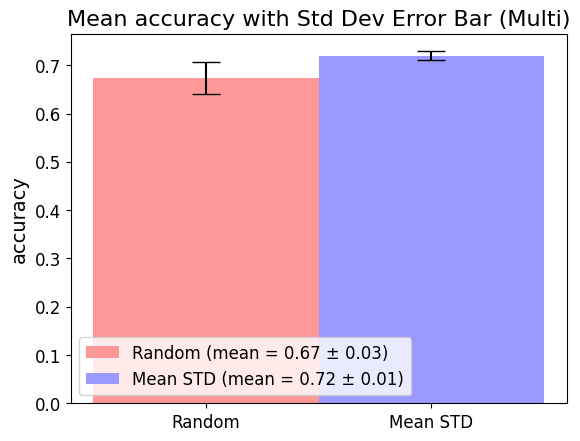

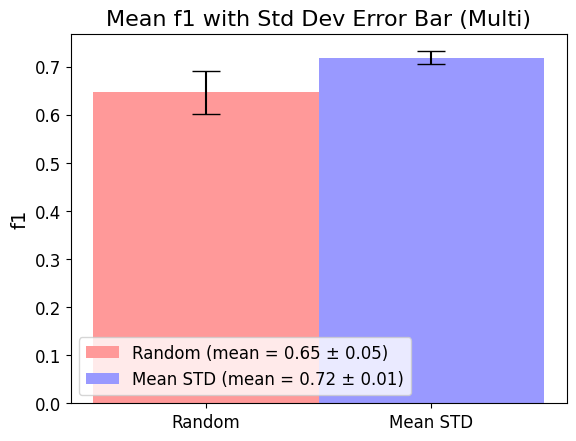

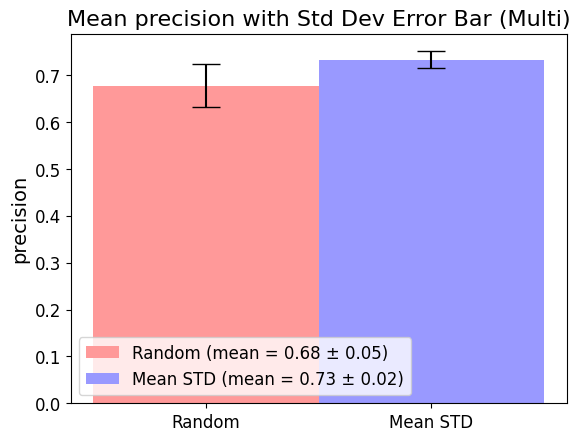

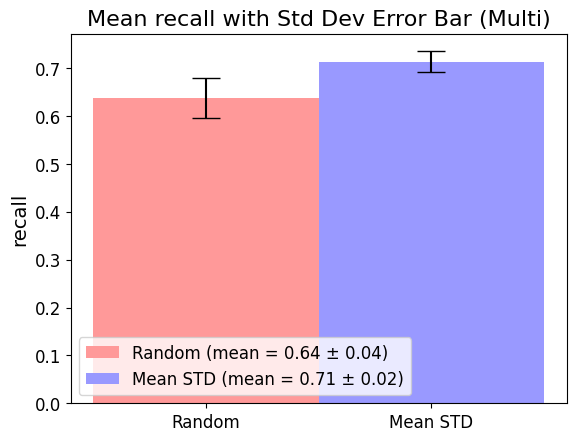

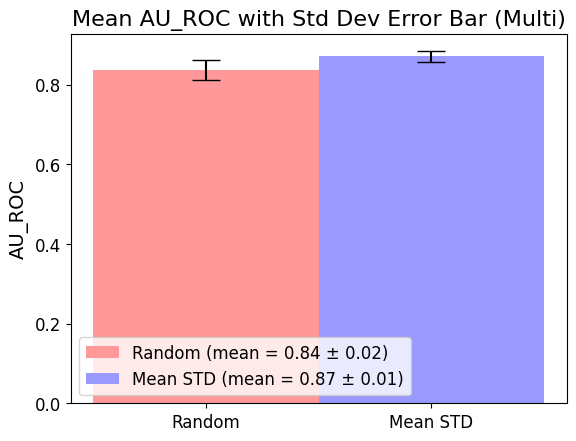

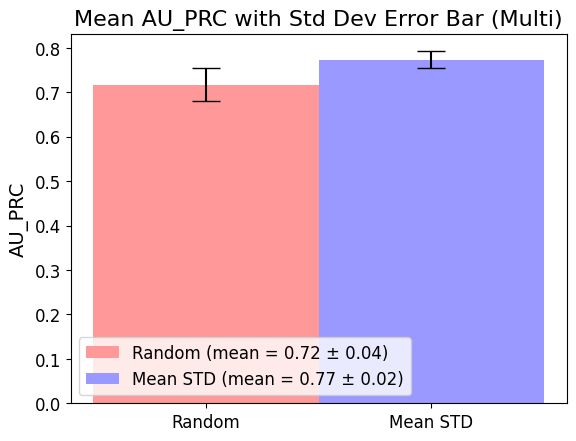

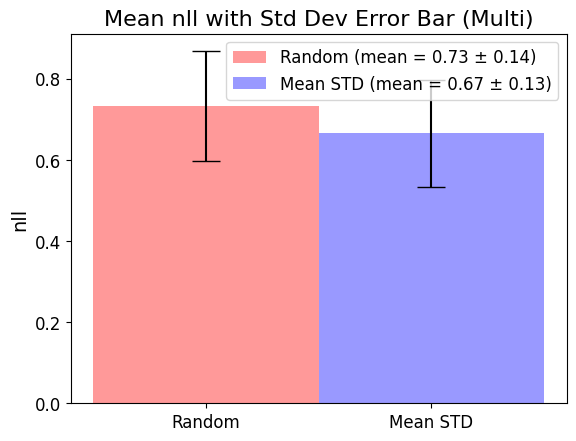

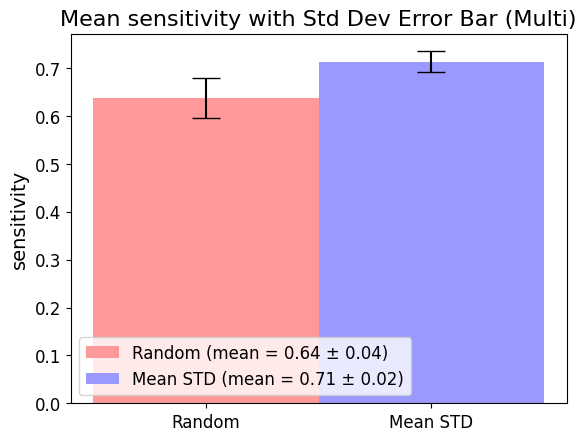

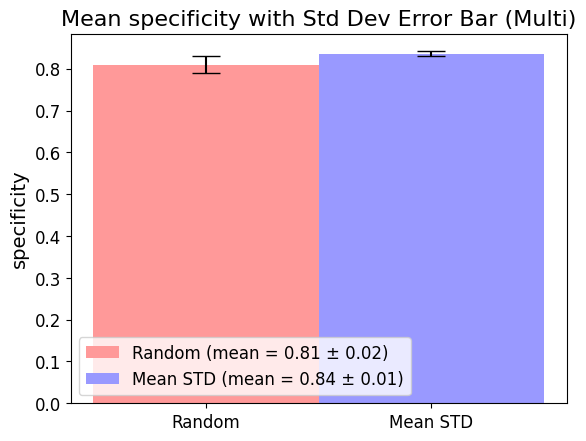

In [71]:
sampler = 'Mean STD'
for metric in metrics:
    mean_random_error, std_random_error, mean_sampler_error, std_sampler_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=False)
    
    # Plotting
    labels = ['Random', sampler]
    mean_errors = [mean_random_error, mean_sampler_error]
    std_errors = [std_random_error, std_sampler_error]
    
    fig, ax = plt.subplots()
    
    # Define the bar width
    bar_width = 1
    
    # Define the positions of the bars
    bar_positions = np.arange(len(labels))
    
    # Plotting the bars
    bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['#FF9999', '#9999FF'])
    
    # Adding legend with mean and standard deviation values
    legend_labels = [
        f'Random (mean = {mean_random_error:.2f} ± {std_random_error:.2f})',
        f'{sampler} (mean = {mean_sampler_error:.2f} ± {std_sampler_error:.2f})'
    ]
    ax.legend(bars, legend_labels, fontsize=12)

    # Labels and title with larger font sizes
    ax.set_ylabel(f'{metric}', fontsize=14)
    ax.set_title(f'Mean {metric} with Std Dev Error Bar (Multi)', fontsize=16)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    output_path = blackhc.notebook.original_dir + f'/COVID_multi_{metric}_vs_random.png'
    alp.plot_save(output_path, dpi=300)
    plt.show()

In [38]:
# samplers = ['Random', 'Entropy Sampling', 'Mean STD']

# # Gather mean and std errors for each sampler
# mean_errors = []
# std_errors = []

# for sampler in samplers:
#     mean_error, std_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=True)
#     mean_errors.append(mean_error)
#     std_errors.append(std_error)

# # Plotting
# labels = samplers

# fig, ax = plt.subplots()

# # Define the bar width
# bar_width = 1

# # Define the positions of the bars
# bar_positions = np.arange(len(labels))

# # Plotting the bars
# bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['blue', 'orange', 'green'])

# # Adding legend with mean and standard deviation values
# legend_labels = [
#     f'{sampler} (mean = {mean_error:.2f} ± {std_error:.2f})' for sampler, mean_error, std_error in zip(samplers, mean_errors, std_errors)
# ]
# ax.legend(bars, legend_labels, fontsize=12)

# # Labels and title with larger font sizes
# ax.set_ylabel('Missclassification Rate', fontsize=14)
# ax.set_title('Mean Missclassification with Std Dev Error Bar (Multi)', fontsize=12)
# ax.set_xticks(bar_positions)
# ax.set_xticklabels(labels, fontsize=12)
# ax.tick_params(axis='y', labelsize=12)

# output_path = blackhc.notebook.original_dir + f'/COVID_multi_missclassification_vs_random.png'
# alp.plot_save(output_path, dpi=300)
# plt.show()

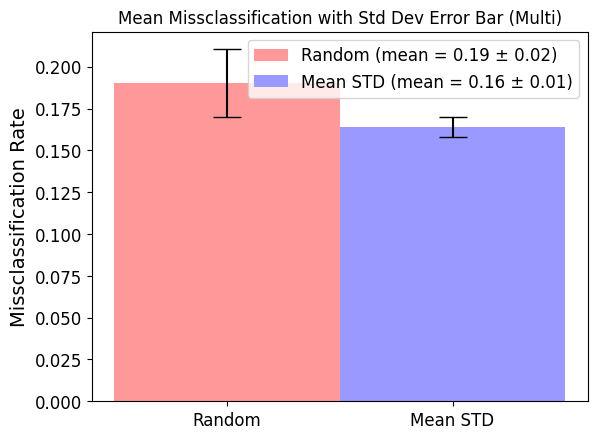

In [72]:
sampler = 'Mean STD'

mean_random_error, std_random_error, mean_sampler_error, std_sampler_error = get_missclass_vals(metric=metric, sampler=sampler, one_minus=True)

# Plotting
labels = ['Random', sampler]
mean_errors = [mean_random_error, mean_sampler_error]
std_errors = [std_random_error, std_sampler_error]

fig, ax = plt.subplots()

# Define the bar width
bar_width = 1

# Define the positions of the bars
bar_positions = np.arange(len(labels))

# Plotting the bars
bars = ax.bar(bar_positions, mean_errors, bar_width, yerr=std_errors, capsize=10, color=['#FF9999', '#9999FF'])

# Adding legend with mean and standard deviation values
legend_labels = [
    f'Random (mean = {mean_random_error:.2f} ± {std_random_error:.2f})',
    f'{sampler} (mean = {mean_sampler_error:.2f} ± {std_sampler_error:.2f})'
]
ax.legend(bars, legend_labels, fontsize=12)

# Labels and title with larger font sizes
ax.set_ylabel(f'Missclassification Rate', fontsize=14)
ax.set_title(f'Mean Missclassification with Std Dev Error Bar (Multi)', fontsize=12)
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

output_path = blackhc.notebook.original_dir + f'/COVID_multi_missclassification_vs_random.png'
alp.plot_save(output_path, dpi=300)
plt.show()